# Unzip File

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/OMSCS/OMSCS_DL_Project/GenImage/BigGAN

/content/drive/.shortcut-targets-by-id/1ZBjY4wyJshfl7CBMcFF38ZcBy5KTYdsC/OMSCS_DL_Project/GenImage/BigGAN


In [5]:
! ls

drive  sample_data


In [3]:
! pwd

/content/drive/.shortcut-targets-by-id/1ZBjY4wyJshfl7CBMcFF38ZcBy5KTYdsC/OMSCS_DL_Project/GenImage/BigGAN


In [ ]:
! ls /content/sample_data

anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md


In [4]:
! unzip unsplit.zip -d /content/sample_data/biggan/

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/biggan/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008906.JPEG  
  inflating: /content/sample_data/biggan/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008909.JPEG  
  inflating: /content/sample_data/biggan/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008920.JPEG  
  inflating: /content/sample_data/biggan/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008926.JPEG  
  inflating: /content/sample_data/biggan/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008936.JPEG  
  inflating: /content/sample_data/biggan/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008940.JPEG  
  inflating: /content/sample_data/biggan/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008945.JPEG  
  inflating: /content/sample_data/biggan/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008953.JPEG  
  inflating: /content/sample_data/biggan/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00

In [ ]:
# %cp -r /content/sample_data/BigGAN/ /content/drive/MyDrive/OMSCS_DL_Project/GenImage/BigGAN/

In [ ]:
# ! zip -F imagenet_ai_0508_adm.zip --out unsplit.zip

## Check Number of files

In [9]:
! ls /content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/ai | wc -l

162000


In [10]:
! ls /content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/nature/ | wc -l

162000


In [11]:
! ls /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/ai | wc -l

6000


In [12]:
! ls /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/ | wc -l

6000


Show Image

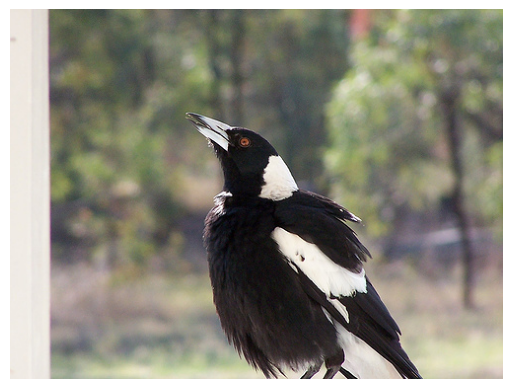

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure()
img = mpimg.imread('/content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/nature/n01582220_4551.JPEG')
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

# Prepare Dataloader

In [13]:
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.io import read_image

import torch

from skimage import io, transform

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
dataset_type = 'val'
model_type = 'nature'
root_dir = '/content/sample_data/sdv4/tensor_imagenet_ai_0419_sdv4'

image_name = os.listdir(os.path.join(root_dir, dataset_type, model_type))


In [ ]:
image_name = os.path.join(root_dir, dataset_type, model_type,image_name[100])
plt.figure()
img = mpimg.imread(image_name)
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
# example: plots do not have three layers
# from IPython.display import Image
# Image(filename='/content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/nature/n02092002_1032.JPEG')

In [14]:
%cd /content/drive/MyDrive/OMSCS/OMSCS_DL_Project/Deep_Learning_Final_Project/Code

/content/drive/.shortcut-targets-by-id/1ZBjY4wyJshfl7CBMcFF38ZcBy5KTYdsC/OMSCS_DL_Project/Deep_Learning_Final_Project/Code


In [ ]:
! ls

Data_Prep_jg.ipynb		epoch0-2023-12-01_03-25-01.pth	__pycache__
data_prep.sh			epoch0-2023-12-01_03-25-51.pth	test.png
data_prep_util.py		epoch0-2023-12-01_03-53-12.pth	trained_weights_BigGAN_epoch1.pth
epoch0-2023-12-01_03-07-03.pth	epoch1-2023-12-01_03-26-30.pth
epoch0-2023-12-01_03-21-52.pth	latest.pth


In [15]:
from data_prep_util import GenImageDataset, Rescale, HighPassConvLayer, State, CheckPoint

# Define Hyperparameters

In [16]:
# Hyperparameters and configurations
class Config:
    # for data loader
    batch_size = 32
    num_workers = 8

    # number of epochs during training
    num_epochs = 1

    # learning rate for learnable parameters
    learning_rate = 3e-5

    # Define an MLP with 2 or 3 layers
    hidden_dim1 = 500
    hidden_dim2 = 500

    # dropout in head
    dropout = 0.1

    # Set to False to disable the high pass filter
    use_filter = True

    # Adjust alpha between 0 and 1 for the desired effect for the high pass filter
    alpha_value = 0.5

    # Set to True if you want to use pretrained weights
    pretrained = False

# Define Transforms

In [1]:
def get_transformations(rescale_size = 256):
    transformations = [Rescale(rescale_size)]
    return transforms.Compose(transformations)


In [2]:
def get_high_freq_representation(image):
    image_gray = transforms.Grayscale()(image)
    fft_result = torch.fft.fft2(image_gray, dim=(-2, -1))
    high_freq_representation = torch.cat([torch.real(fft_result), torch.imag(fft_result)], dim=0)
    highfreq_image = torch.cat([high_freq_representation,image])
    return high_freq_representation

In [3]:
dataset_type = 'train'
# model_type = 'nature'
root_dir = '/content/sample_data/sdv4/tensor_imagenet_ai_0419_sdv4'

BigGen_train_nature = GenImageDataset(root_dir, dataset_type, 'nature',
                                      transform=get_transformations(), highfreq = get_high_freq_representation())

BigGen_train_ai = GenImageDataset(root_dir, dataset_type, 'ai',
                                  transform=get_transformations())

BigGen_train = torch.utils.data.ConcatDataset([BigGen_train_nature, BigGen_train_ai])

NameError: ignored

In [ ]:
dataset_type = 'val'

BigGen_val_nature = GenImageDataset(root_dir, dataset_type, 'nature',
                                    transform=get_transformations())

BigGen_val_ai = GenImageDataset(root_dir, dataset_type, 'ai',
                                transform=get_transformations())

BigGen_val = torch.utils.data.ConcatDataset([BigGen_val_nature, BigGen_val_ai])

In [ ]:
len(BigGen_train)

In [ ]:
len(BigGen_val)

In [ ]:
BigGen_train[100]

In [ ]:
BigGen_train[100]['image'].shape

In [ ]:
plt.figure()
img = BigGen_train[100]['image']
imgplot = plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [ ]:
next(iter(BigGen_train))

# Create Dataloader

In [ ]:
# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(BigGen_train, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(BigGen_val, batch_size=64, shuffle=True)

https://discuss.pytorch.org/t/dataloader-resets-dataset-state/27960

https://discuss.pytorch.org/t/pytorch-dataloaders-in-memory/118471

# Try Swin Transform

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [ ]:
# Wrapper for Swin Transformer to allow optional conv layer
class CustomSwinModel(nn.Module):
    def __init__(self, base_model, use_high_pass_filter=False):
        super(CustomSwinModel, self).__init__()
        self.use_high_pass_filter = use_high_pass_filter
        self.high_pass_filter = HighPassConvLayer(
        ) if use_high_pass_filter else nn.Identity()
        self.base_model = base_model

    def forward(self, x):
        if self.use_high_pass_filter:
            x = self.high_pass_filter(x)
        return self.base_model(x)


# Uncomment to load the pre-trained Swin Transformer model
# model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1, progress=True)

# Initialize the Swin Transformer model without pretrained weights
base_model = models.swin_t(pretrained=Config.pretrained)  # Notice pretrained is set to False

# Create the custom model with the high-pass filter layer
model = CustomSwinModel(base_model, use_high_pass_filter=Config.use_filter)


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

'''
For transfer learning, uncomment to freeze the pretrained weights
'''
# for param in model.parameters():
#     param.requires_grad = False

classes = ['ai','nature']

mlp_head = nn.Sequential(
    nn.Linear(model.base_model.head.in_features, Config.hidden_dim1),
    nn.ReLU(),
    nn.Dropout(Config.dropout),
    nn.Linear(Config.hidden_dim1, Config.hidden_dim2),
    nn.ReLU(),
    nn.Dropout(Config.dropout),
    nn.Linear(Config.hidden_dim2, len(classes))
).to(device)

# Update the classifier head of the base_model inside CustomSwinModel
model.base_model.head = mlp_head

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
criterion = nn.CrossEntropyLoss()

def accuracy(predictions, labels):
    _, preds = torch.max(predictions, 1)
    return (preds == labels).float().mean().item()

In [ ]:
trainloader = DataLoader(BigGen_train, batch_size=Config.batch_size, shuffle=True)
testloader = DataLoader(BigGen_val, batch_size=Config.batch_size, shuffle=True)

In [ ]:
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import time  # Import the time module

scaler = GradScaler()  # Initialize the GradScaler

train_loss_history, val_loss_history, train_acc_history, val_acc_history = {}, {}, {}, {}
total_training_start = time.time()  # Record the start time of the total training
starting_epoch = 0
load_latest_model = False

state = CheckPoint.load_checkpoint()
if state is not None and load_latest_model:
    print('LOADING FROM CHECKPOINT')
    model.load_state_dict(state.model_state_dict)
    starting_epoch = state.epoch + 1
    trainloader = state.trainloader
    testloader = state.testloader
    train_loss_history = state.train_loss_history
    train_acc_history = state.train_acc_history
    val_loss_history = state.val_loss_history
    val_acc_history = state.val_acc_history
    criterion.load_state_dict(state.criterion_state_dict)
    optimizer.load_state_dict(state.optimizer_state_dict)
    scaler.load_state_dict(state.scaler_state_dict)
    print('starting_epoch', starting_epoch)
    print('train_loss_history', train_loss_history)
    print('train_acc_history', train_acc_history)
    print('val_loss_history', val_loss_history)
    print('val_acc_history', val_acc_history)

for epoch in range(starting_epoch, Config.num_epochs):
    epoch_start = time.time()  # Record the start time of the epoch

    train_loss, train_acc, val_loss, val_acc = 0.0, 0.0, 0.0, 0.0
    train_loss_history[epoch] = []
    val_loss_history[epoch] = []
    train_acc_history[epoch] = []
    val_acc_history[epoch] = []

    # Training Phase
    model.train()
    pbar = tqdm(enumerate(trainloader), total=len(trainloader),
                desc=f"Epoch {epoch+1} TRAIN", ncols=100)
    for i, data in pbar:
        inputs = data['image']
        inputs = inputs.to(torch.float)
        inputs = inputs.to(device)

        labels = data['model_type']
        labels = labels.to(device)

        dataset = data['dataset_type']
        image_name = data['image_name']

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = accuracy(outputs, labels)
        train_loss_history[epoch].append(loss.item())
        train_acc_history[epoch].append(acc)

        train_loss += loss.item()
        train_acc += acc

        pbar.set_description(f"Epoch {epoch+1} TRAIN Loss: {loss.item():.4f}")

    # Validation Phase
    model.eval()
    pbar = tqdm(enumerate(testloader), total=len(testloader),
                desc=f"Epoch {epoch+1} VAL", ncols=100)
    with torch.no_grad():
        for i, data in pbar:
            inputs = data['image']
            inputs = inputs.to(torch.float)
            inputs = inputs.to(device)

            labels = data['model_type']
            labels = labels.to(device)

            dataset = data['dataset_type']
            image_name = data['image_name']

            # inputs, labels, dataset = inputs.cuda(), labels.cuda(), dataset.cuda()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            acc = accuracy(outputs, labels)
            val_loss_history[epoch].append(loss.item())
            val_acc_history[epoch].append(acc)

            val_loss += loss.item()
            val_acc += acc

            pbar.set_description(
                f"Epoch {epoch+1} VAL Loss: {loss.item():.4f}")

    epoch_end = time.time()  # Record the end time of the epoch
    # Calculate the duration in minutes
    epoch_duration = (epoch_end - epoch_start) / 60

    train_loss /= len(trainloader)
    train_acc /= len(trainloader)
    val_loss /= len(testloader)
    val_acc /= len(testloader)

    print(f"Epoch Summary {epoch+1}/{Config.num_epochs}")
    print(
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    print(f"Epoch Duration: {epoch_duration:.2f} minutes")
    print('-' * 60)

    state = State(
        model_state_dict = model.state_dict(),
        epoch = epoch,
        trainloader = trainloader,
        testloader = testloader,
        train_loss_history = train_loss_history,
        train_acc_history = train_acc_history,
        val_loss_history = val_loss_history,
        val_acc_history = val_acc_history,
        criterion_state_dict = criterion.state_dict(),
        optimizer_state_dict = optimizer.state_dict(),
        scaler_state_dict = scaler.state_dict(),
    )
    CheckPoint.save_checkpoint(state)

total_training_end = time.time()  # Record the end time of the total training
# Calculate the total duration in minutes
total_training_duration = (total_training_end - total_training_start) / 60
print('Finished Training')
print(f"Total Training Time: {total_training_duration:.2f} minutes")

# https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch

Epoch 1 TRAIN:   0%|                                                      | 0/10125 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epoch 1 TRAIN Loss: 0.2544:   2%|▌                              | 171/10125 [00:34<33:01,  5.02it/s]

In [ ]:
import matplotlib.pyplot as plt

training_losses = []
training_acc = []
validation_losses = []
validation_acc = []

# combine loss maps into a single array
for epoch in train_loss_history:
  training_losses += train_loss_history[epoch]
  training_acc += train_acc_history[epoch]
  validation_losses += val_loss_history[epoch]
  validation_acc += val_acc_history[epoch]

plt.plot(training_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.legend(loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig('losses.png')

plt.clf()

plt.plot(training_acc, label='train')
plt.plot(validation_acc, label='validation')
plt.legend(loc='upper left')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.savefig('accuracies.png')

In [ ]:
# from itertools import islice

# for i,data in enumerate(trainloader):
#   if i>5200:
#     print(data['image'].shape)
#     print(i)


In [ ]:
# plots with errors
# /content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/ai/116_biggan_00098.png
# /content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/ai/116_biggan_00107.png
plt.figure()
img = mpimg.imread('/content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/ai/116_biggan_00094.png')
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
import gc

del model, inputs, labels, dataset, image_name
gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)